# Classification Trees and Random Forest Classification (supermarket data)

In this notebook, we will use Classification Tree and Random Forest classifiers to predict supermarket brands based on various features like location, population density, brand, and more. We will evaluate the models using feature importance, confusion matrices, and ROC curves.

## Libraries and settings

In [1]:
# Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

from sklearn import tree
from sklearn.metrics import RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Show current working directory
print(os.getcwd())

/workspaces/python_machine_learning_basics/CART_RandomForest


## Import supermarkets data

In [2]:
# Read and select variables
columns = ['id',
           'bfs_name',
           'bfs_number',
           'lat',
           'lon',
           'brand',
           'pop',
           'pop_dens',
           'frg_pct',
           'emp',
          ]
df_supermarkets_orig = pd.read_csv("./Data/supermarkets_data_enriched.csv", 
                                   sep=",", 
                                   encoding="utf-8")[columns]

# Number of rows and columns
print(df_supermarkets_orig.shape)

# Brand to upper case letters
df_supermarkets_orig['brand'] = df_supermarkets_orig['brand'].str.upper()

# First records
df_supermarkets_orig.head(5)

(3242, 10)


,id,bfs_name,bfs_number,lat,lon,brand,pop,pop_dens,frg_pct,emp
0,33126515,Schänis,3315,47.155616,9.037915,SPAR,3876,97.142857,13.054696,1408.0
1,280130028,Schänis,3315,47.155492,9.039666,ALDI,3876,97.142857,13.054696,1408.0
2,6122906632,Schänis,3315,47.158959,9.044477,DENNER,3876,97.142857,13.054696,1408.0
3,9019298862,Schänis,3315,47.155185,9.038472,LIDL,3876,97.142857,13.054696,1408.0
4,36726161,Uznach,3339,47.226191,8.980329,MIGROS,6489,860.610080,27.862537,3500.0


## Count and remove missing values

In [3]:
# Count missing values
print(df_supermarkets_orig.isna().sum())

# Remove missing values
df_supermarkets = df_supermarkets_orig.dropna()
df_supermarkets

id               0
bfs_name         0
bfs_number       0
lat              0
lon              0
brand         1233
pop              0
pop_dens         0
frg_pct          0
emp             45
dtype: int64


,id,bfs_name,bfs_number,lat,lon,brand,pop,pop_dens,frg_pct,emp
0,33126515,Schänis,3315,47.155616,9.037915,SPAR,3876,97.142857,13.054696,1408.0
1,280130028,Schänis,3315,47.155492,9.039666,ALDI,3876,97.142857,13.054696,1408.0
2,6122906632,Schänis,3315,47.158959,9.044477,DENNER,3876,97.142857,13.054696,1408.0
3,9019298862,Schänis,3315,47.155185,9.038472,LIDL,3876,97.142857,13.054696,1408.0
4,36726161,Uznach,3339,47.226191,8.980329,MIGROS,6489,860.610080,27.862537,3500.0
...,...,...,...,...,...,...,...,...,...,...
3230,9584570723,Seedorf (UR),1214,46.881529,8.615975,VOLG,2051,106.379668,6.972209,703.0
3231,9593770082,Bäretswil,111,47.339296,8.839173,VOLG,5053,227.715187,10.152385,1647.0
3233,9624205242,Buch am Irchel,24,47.549645,8.618709,VOLG,979,95.886386,7.252298,200.0
3238,9950926547,Marbach (SG),3253,47.392404,9.569855,VOLG,2110,481.735160,18.578199,678.0


## Subset with selected brands

In [4]:
df_sub = df_supermarkets.loc[df_supermarkets['brand'].isin(['MIGROS', 'VOLG'])]
print(df_sub.shape)
df_sub.head()

(696, 10)


,id,bfs_name,bfs_number,lat,lon,brand,pop,pop_dens,frg_pct,emp
4,36726161,Uznach,3339,47.226191,8.980329,MIGROS,6489,860.610080,27.862537,3500.0
8,48932835,Zürich,261,47.375020,8.522895,MIGROS,420217,4778.994655,32.458468,491193.0
11,83330862,Zürich,261,47.344749,8.529981,MIGROS,420217,4778.994655,32.458468,491193.0
12,119249170,Zürich,261,47.375255,8.536107,MIGROS,420217,4778.994655,32.458468,491193.0
15,262400822,Zürich,261,47.364072,8.530945,MIGROS,420217,4778.994655,32.458468,491193.0


## Pivot table

In [5]:
# Using pivot_table to reshape the data and calculate means 
pd.pivot_table(df_sub[['lat',
                       'lon',
                       'brand',
                       'pop',
                       'pop_dens',
                       'frg_pct',
                       'emp']],
                index=['brand'],
                values=['lat', 'lon', 'pop', 'pop_dens', 'frg_pct', 'emp'],
                aggfunc=(np.mean, 'count')).round(0)

emp          frg_pct         lat         lon        pop           \
       count     mean   count  mean count  mean count mean count     mean   
brand                                                                       
MIGROS   486  60264.0     486  28.0   486  47.0   486  8.0   486  58452.0   
VOLG     210   2382.0     210  16.0   210  47.0   210  9.0   210   4811.0   

       pop_dens          
          count    mean  
brand                    
MIGROS      486  2016.0  
VOLG        210   363.0

## Classification Tree
For details see: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

### Create train and test samples (train = 80%, test = 20% of the data)

In [6]:
# Create train and test samples
X_train, X_test, y_train, y_test = train_test_split(df_sub[['lat',
                                                            'lon',
                                                            'pop', 
                                                            'pop_dens', 
                                                            'frg_pct', 
                                                            'emp']],
                                                    df_sub['brand'], 
                                                    test_size=0.20, 
                                                    random_state=42)

# Show X_train
print('X_train:')
print(X_train.head(), '\n')

# Show y_train
print('y_train:')
print(y_train.head())

X_train:
            lat       lon     pop      pop_dens    frg_pct       emp
427   46.767777  9.062487    1728     17.891903   8.217593     725.0
271   47.552670  7.592713  173232   7263.396226  37.955459  185432.0
1149  46.203871  6.146234  203951  12810.992462  47.954656  186620.0
2655  46.774599  9.207659    4757     35.638298  16.312802    3229.0
2369  47.126317  7.246363    6872   4521.052632  26.062282    3185.0 

y_train:
427       VOLG
271     MIGROS
1149    MIGROS
2655    MIGROS
2369    MIGROS
Name: brand, dtype: object


### Fit the classification tree model and make predictions

In [7]:
# Initialize the classification tree model 
clf = DecisionTreeClassifier(random_state=42, 
                             max_depth=5)

# Train the classification tree model 
clf = clf.fit(X_train, y_train)

# Make model predictions
y_pred = clf.predict(X_test)
y_pred

array(['MIGROS', 'MIGROS', 'MIGROS', 'MIGROS', 'MIGROS', 'MIGROS',
       'MIGROS', 'MIGROS', 'VOLG', 'MIGROS', 'VOLG', 'MIGROS', 'MIGROS',
       'MIGROS', 'MIGROS', 'VOLG', 'VOLG', 'VOLG', 'VOLG', 'VOLG',
       'MIGROS', 'MIGROS', 'VOLG', 'MIGROS', 'MIGROS', 'VOLG', 'VOLG',
       'MIGROS', 'VOLG', 'MIGROS', 'MIGROS', 'VOLG', 'MIGROS', 'MIGROS',
       'MIGROS', 'MIGROS', 'MIGROS', 'MIGROS', 'MIGROS', 'MIGROS',
       'MIGROS', 'MIGROS', 'VOLG', 'VOLG', 'VOLG', 'MIGROS', 'VOLG',
       'MIGROS', 'MIGROS', 'MIGROS', 'MIGROS', 'MIGROS', 'MIGROS',
       'MIGROS', 'MIGROS', 'MIGROS', 'VOLG', 'MIGROS', 'VOLG', 'VOLG',
       'MIGROS', 'MIGROS', 'MIGROS', 'MIGROS', 'MIGROS', 'MIGROS',
       'MIGROS', 'MIGROS', 'MIGROS', 'MIGROS', 'MIGROS', 'MIGROS', 'VOLG',
       'MIGROS', 'MIGROS', 'VOLG', 'MIGROS', 'MIGROS', 'MIGROS', 'MIGROS',
       'VOLG', 'MIGROS', 'VOLG', 'MIGROS', 'MIGROS', 'MIGROS', 'MIGROS',
       'MIGROS', 'MIGROS', 'MIGROS', 'MIGROS', 'VOLG', 'MIGROS', 'MIGROS',
       'MI

### Show confusion matrix and classification report

In [8]:
# Confusion matrix
print('Confusion matrix')
print(confusion_matrix(y_test, y_pred), '\n')

# Classification report
print('Classification report')
print(classification_report(y_test, y_pred))

Confusion matrix
[[97 11]
 [ 7 25]] 

Classification report
              precision    recall  f1-score   support

      MIGROS       0.93      0.90      0.92       108
        VOLG       0.69      0.78      0.74        32

    accuracy                           0.87       140
   macro avg       0.81      0.84      0.83       140
weighted avg       0.88      0.87      0.87       140



### Print text representation of the classification tree

In [9]:
# Text representation of the classification tree
text_rep = tree.export_text(clf, 
                            feature_names=list(X_train.columns))

# Print text_representation
print(text_rep)

|--- emp <= 1399.00
|   |--- pop <= 2598.50
|   |   |--- lat <= 46.35
|   |   |   |--- emp <= 512.50
|   |   |   |   |--- pop <= 682.50
|   |   |   |   |   |--- class: VOLG
|   |   |   |   |--- pop >  682.50
|   |   |   |   |   |--- class: MIGROS
|   |   |   |--- emp >  512.50
|   |   |   |   |--- class: VOLG
|   |   |--- lat >  46.35
|   |   |   |--- emp <= 824.00
|   |   |   |   |--- class: VOLG
|   |   |   |--- emp >  824.00
|   |   |   |   |--- emp <= 856.50
|   |   |   |   |   |--- class: MIGROS
|   |   |   |   |--- emp >  856.50
|   |   |   |   |   |--- class: VOLG
|   |--- pop >  2598.50
|   |   |--- lat <= 46.87
|   |   |   |--- frg_pct <= 30.43
|   |   |   |   |--- pop_dens <= 21.35
|   |   |   |   |   |--- class: VOLG
|   |   |   |   |--- pop_dens >  21.35
|   |   |   |   |   |--- class: MIGROS
|   |   |   |--- frg_pct >  30.43
|   |   |   |   |--- class: VOLG
|   |   |--- lat >  46.87
|   |   |   |--- pop_dens <= 750.01
|   |   |   |   |--- pop_dens <= 387.54
|   |   |   |  

## Visualize the classification tree

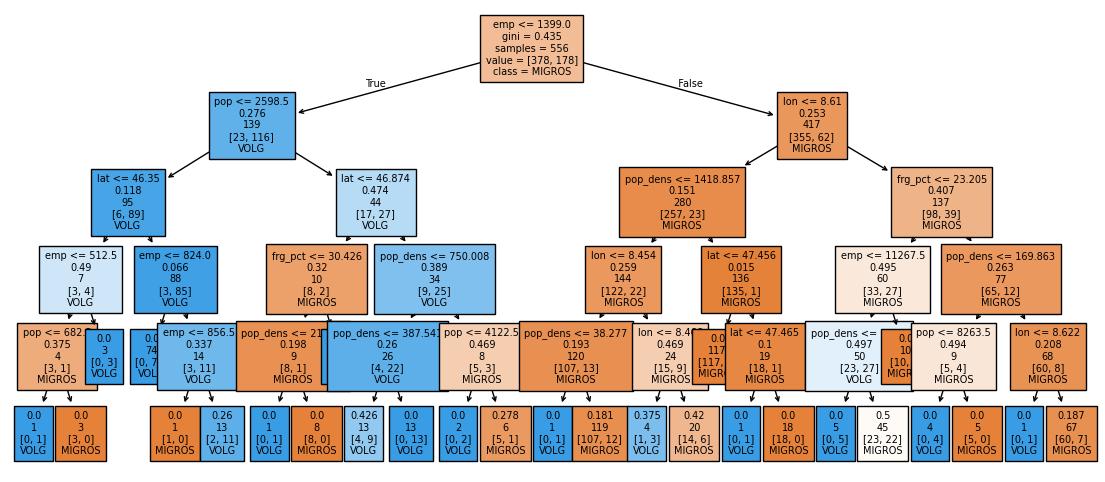

In [10]:
# For the meaning of numbers in boxes see root node
fig = plt.figure(figsize=(14,6))
tree_plot = tree.plot_tree(clf, 
                   feature_names=list(X_train.columns),  
                   class_names=['MIGROS', 'VOLG'],
                   filled=True,
                   fontsize=7,
                   label='root')

## Random Forest Classifier
For details see: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

### Create train and test samples (train = 80%, test = 20% of the data)

In [11]:
# Create train and test samples
X2_train, X2_test, y2_train, y2_test = train_test_split(df_sub[['lat',
                                                                'lon',
                                                                'pop', 
                                                                'pop_dens', 
                                                                'frg_pct', 
                                                                'emp']],
                                                        df_sub['brand'], 
                                                        test_size=0.20, 
                                                        random_state=5)

# Show X2_train
print('X2_train:')
print(X2_train.head(), '\n')

# Show y2_train
print('y2_train:')
print(y2_train.head())

X2_train:
            lat       lon    pop     pop_dens    frg_pct     emp
2814  47.388170  8.253929   2445   315.483871  14.683027   858.0
2425  46.259128  7.902847   1337    25.895797   4.936425   539.0
2473  47.169307  7.524045   2844   634.821429   8.368495  1037.0
2705  46.527225  6.602452  12413  5642.272727  41.843229  6748.0
2839  47.450087  9.650465   5960   867.540029  49.580537  3158.0 

y2_train:
2814      VOLG
2425      VOLG
2473      VOLG
2705    MIGROS
2839    MIGROS
Name: brand, dtype: object


### Fit the Random Forest Classifier

In [12]:
# Initialize the random forest classifier
rfc = RandomForestClassifier(n_estimators=500, random_state=42, max_depth=5)

# Train the classification tree model
rfc = rfc.fit(X2_train, y2_train)

# Predict the target variable
y_pred_rf = rfc.predict(X2_test)

# Crosstab
print('Brand versus predicted brand:', '\n')
df_pred = pd.DataFrame(data={'brand': y2_test, 
                             'brand_predicted': y_pred_rf}).reset_index(drop=True)
df_pred

Brand versus predicted brand: 



,brand,brand_predicted
0,MIGROS,MIGROS
1,MIGROS,MIGROS
2,MIGROS,MIGROS
3,VOLG,MIGROS
4,MIGROS,MIGROS
...,...,...
135,MIGROS,MIGROS
136,MIGROS,MIGROS
137,MIGROS,MIGROS
138,VOLG,MIGROS


### Show confusion matrix and classification report

In [13]:
# Confusion matrix
print('Confusion matrix')
print(confusion_matrix(y2_test, y_pred_rf), '\n')

# Classification report
print('Classification report')
print(classification_report(y2_test, y_pred_rf))

Confusion matrix
[[98  6]
 [ 8 28]] 

Classification report
              precision    recall  f1-score   support

      MIGROS       0.92      0.94      0.93       104
        VOLG       0.82      0.78      0.80        36

    accuracy                           0.90       140
   macro avg       0.87      0.86      0.87       140
weighted avg       0.90      0.90      0.90       140



### Show feature importance

Index(['emp', 'pop', 'frg_pct', 'pop_dens', 'lon', 'lat'], dtype='object')
[0.29380007 0.27210589 0.15087431 0.13026407 0.08730287 0.06565278]


<Axes: ylabel='features'>

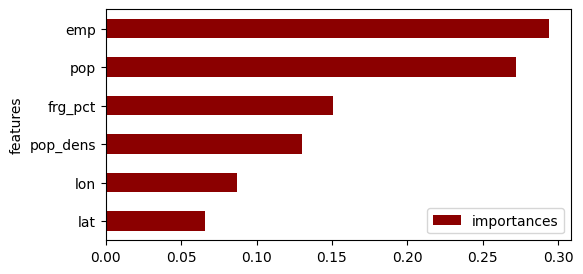

In [14]:
cols = X2_train.columns

# Derive feature importance from the random forest classifier
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print col-names and importances-values
print( cols[indices] )
print( importances[indices] )

# Barplot with feature importance
df_fi = pd.DataFrame({'features':cols,'importances': importances})
df_fi.sort_values('importances', inplace=True)
df_fi.plot(kind='barh', 
           y='importances', 
           x='features', 
           color='darkred', 
           figsize=(6,3))

### ROC curve and AUC

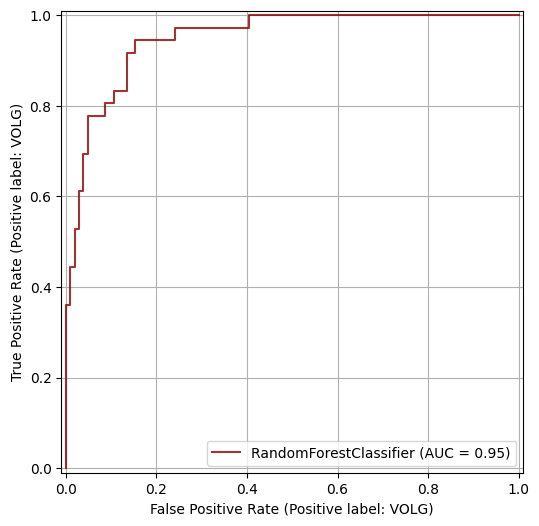

In [15]:
# Plot ROC curve and calculate AUC
plt.figure(figsize=(6,6))
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rfc, 
                                          X2_test, 
                                          y2_test, 
                                          ax=ax,
                                          alpha=0.8,
                                          c="darkred")
plt.grid()
plt.show()

### Jupyter notebook --footer info-- (please always provide this at the end of each submitted notebook)

In [16]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Linux | 6.8.0-1030-azure
Datetime: 2025-10-27 10:28:02
Python Version: 3.11.14
-----------------------------------
